# Data Examination (Wind)

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Wind Total [MW]
count,35064.000000
mean,3514.899088
std,2596.539595
min,32.312500
25%,1439.359375
50%,2804.062500
75%,5067.703125
max,12068.000000


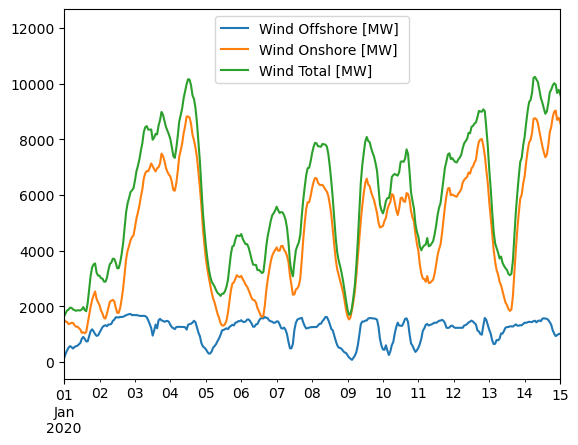

In [2]:
# Import Supply Dataset

sData = pd.read_csv('../Seminar_2024_Data/Realised_Supply_Germany.csv', sep=';', 
                   decimal=',', thousands='.', usecols=[0,1,4,5], dtype={'Date from': object, 'Date to': object})

# casting Year column to datetime object
sData['Date from'] = pd.to_datetime(sData['Date from'], format="%d.%m.%y %H:%M", dayfirst=True) 

# Create new date range as index with frequency (using the one from sData caused trouble)
date_rng = pd.date_range(start='2019-01-01 00:00', end='2022-12-31 23:45', freq='15min')

# Setting index 
sData = sData.set_index(date_rng)

# Drop Date columns
sData = sData.drop(columns=['Date to', 'Date from'])

# Add Onshore and OffShore Wind together

sData["Wind Total [MW]"] = sData["Wind Offshore [MW] "] + sData["Wind Onshore [MW]"]

# Aggregate Rows into 1 hour steps
sData = sData.resample('h').mean()

# set the recording frequency of the data
sData = sData.asfreq('h')

# Add shifted values (24 hours back) for use as exogenous variable
#sData["pv_lagged"] = sData["Photovoltaic [MW]"].shift(24)

# Drop rows with NaN values (first 24 hours have NaN in "pv_lagged")
#sData.dropna(inplace=True)


# Plot
sData.plot()
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2020-01-15')
plt.xlim(start_date, end_date)

# Drop unused cols
sData = sData.drop(columns=["Wind Offshore [MW] ", "Wind Onshore [MW]"])

# Split Dataset
train_data, test_data = sData[:"2021-12-31 23:00:00"].copy(), sData["2022-01-01 00:00:00":].copy()

#sData.plot()
sData.describe()

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(sData)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -14.188290056768972
p-value: 1.8760805113973418e-26
Critical Values:
   1%: -3.4305367814665044
   5%: -2.8616225527935106
   10%: -2.566813940257257


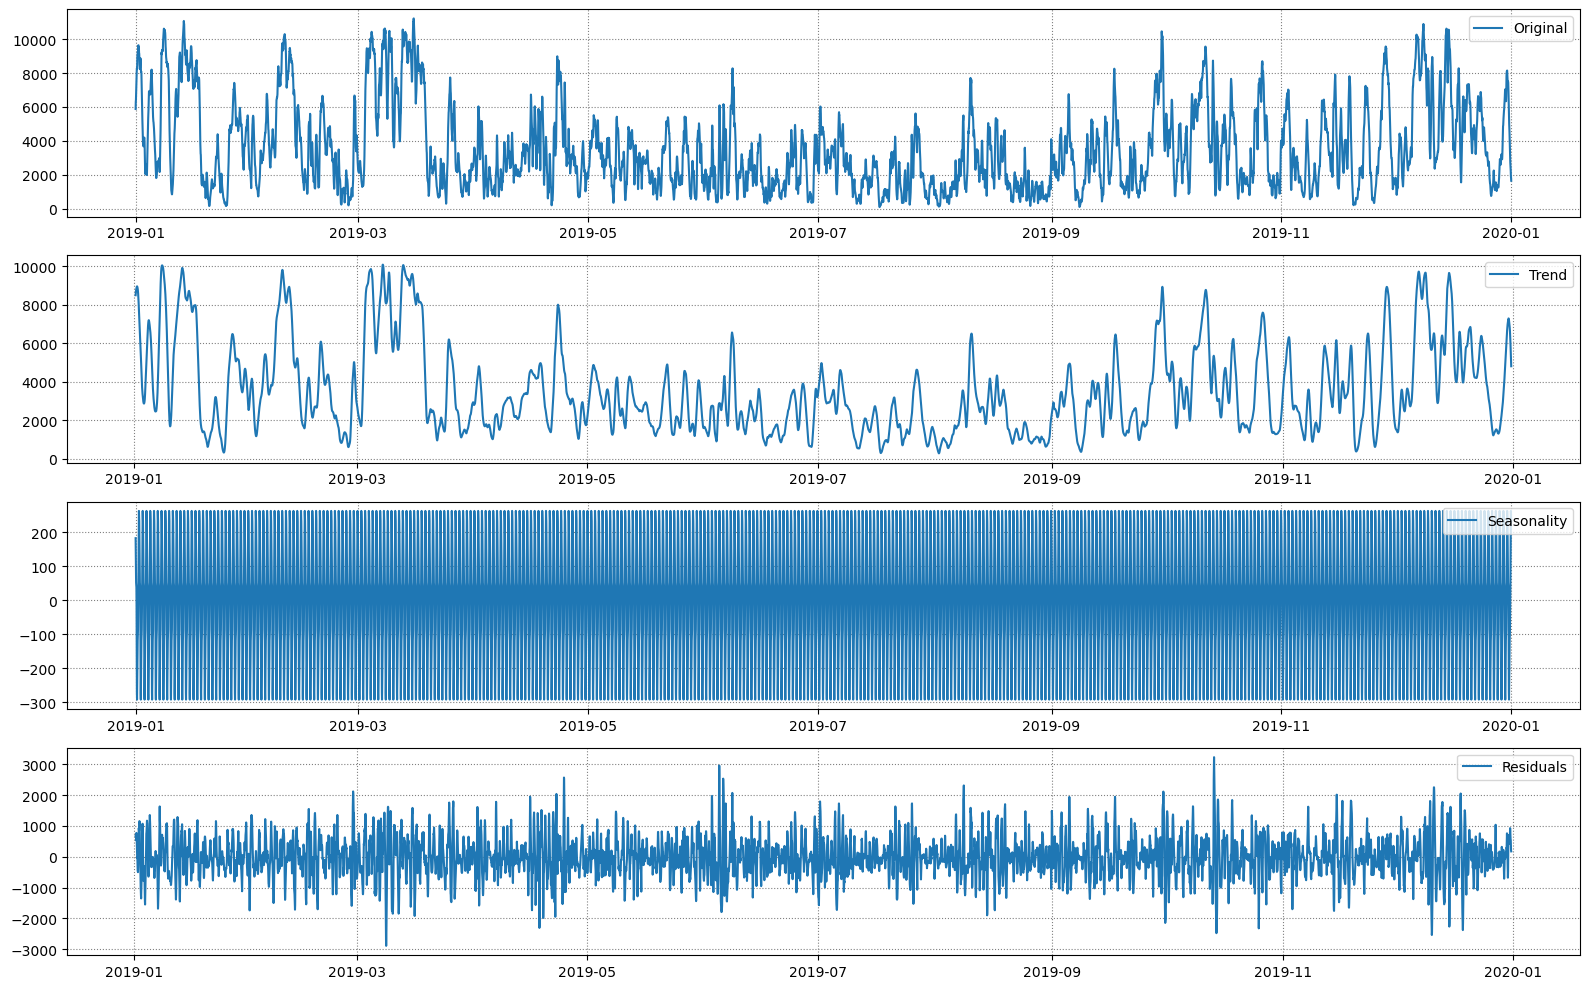

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_series(df: pd.DataFrame) -> None:
    """
    This function decomposes the time series
    into trend, seasonality and residuals.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    # Decomposition
    decomposition = seasonal_decompose(df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    #Figure
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(16,10), facecolor='w')

    ax1.plot(df, label='Original')
    ax2.plot(trend, label='Trend')
    ax3.plot(seasonal,label='Seasonality')
    ax4.plot(residual, label='Residuals')
    
    # Legend
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    ax4.legend(loc='upper right')
    
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')
    ax4.grid(linestyle=":", color='grey')

    #plt.title('Decomposed')
    plt.tight_layout()
    plt.show()

decompose_series(sData["Wind Total [MW]"][:"2019-12-31"])
#decompose_series(sData["Photovoltaic [MW]"].resample("d").mean())

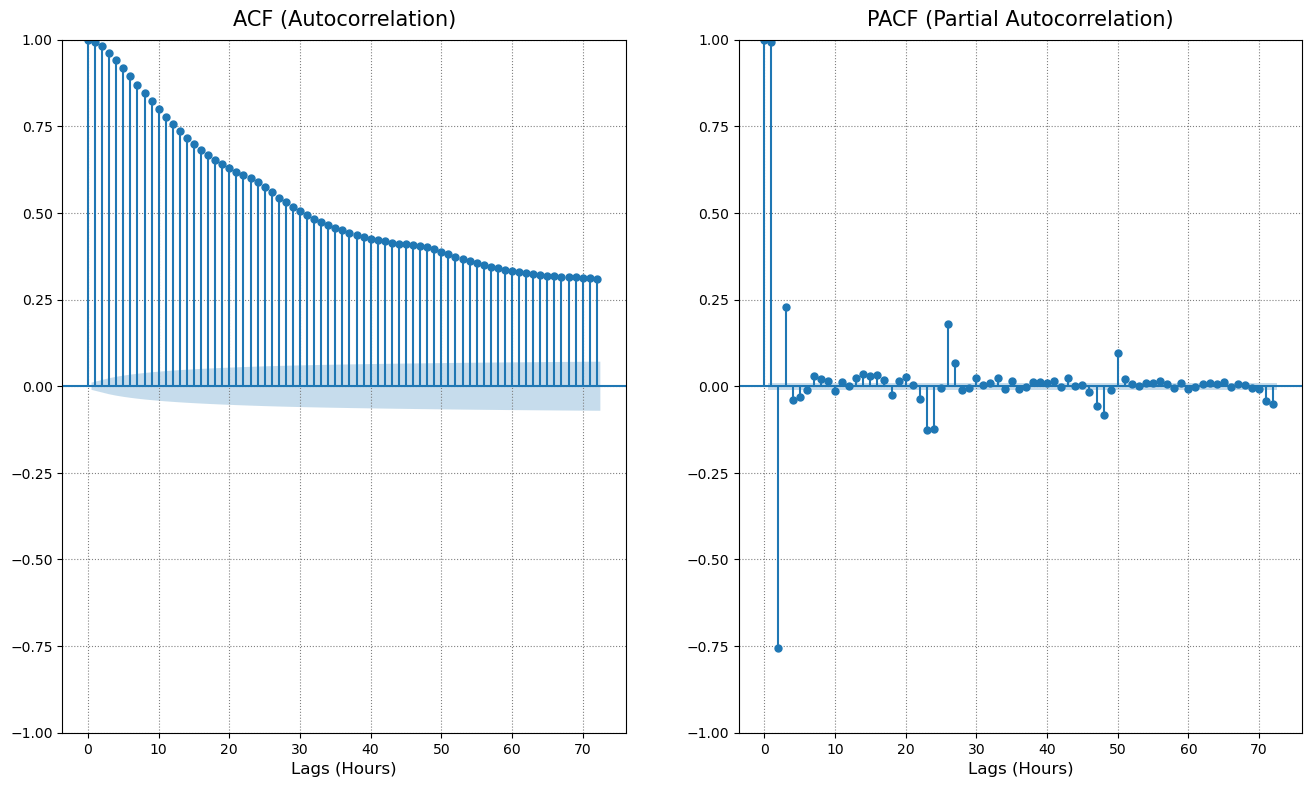

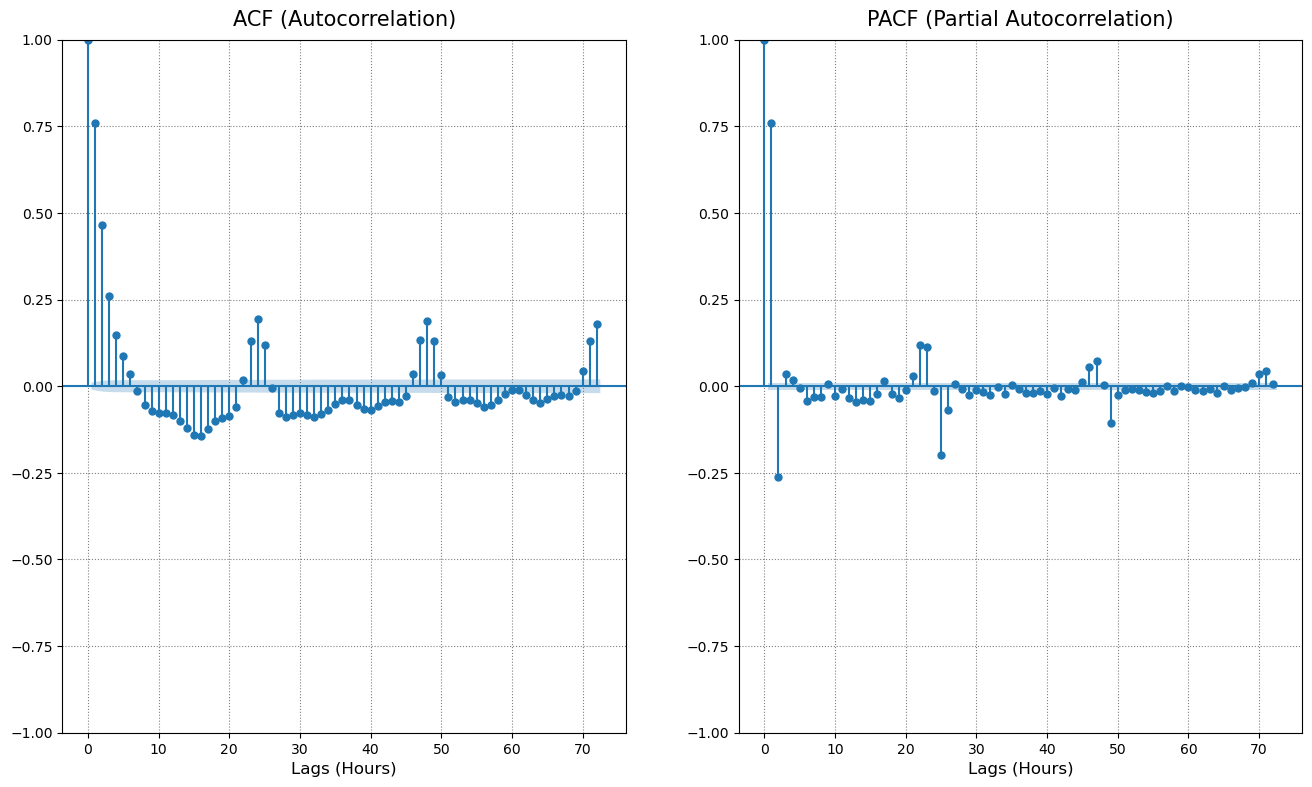

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(df: pd.DataFrame, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')
    
    # ACF & PACF
    plot_acf(df, ax=ax1, lags=acf_lags)
    plot_pacf(df, ax=ax2, lags=pacf_lags, method='ywm')

    # Labels
    ax1.set_title("ACF (Autocorrelation)", fontsize=15, pad=10)
    ax1.set_xlabel("Lags (Hours)", fontsize=12)

    ax2.set_title("PACF (Partial Autocorrelation)", fontsize=15, pad=10)
    ax2.set_xlabel("Lags (Hours)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()



plot_acf_pacf(sData["Wind Total [MW]"], acf_lags=72, pacf_lags= 72)

# Use differenced Series:
sData_diff = sData.diff().dropna()
plot_acf_pacf(sData_diff["Wind Total [MW]"], acf_lags=72, pacf_lags= 72)